In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.optimize import curve_fit

import uncertainties as un
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values, std_devs
err = std_devs
nom = nominal_values

from li_funks.plot import savefig

In [2]:
df = pd.read_pickle('data/processed_LiDataFull.pkl')  # use pickle to preserve uncertainty info
sdf = pd.read_pickle('data/processed_LiDataSummary.pkl')  # use pickle to preserve uncertainty info

## Plot Parameters

In [3]:
# database = 'minteq.v4'  # which solution chemistry calculation to use -- minteq.v4 or pitzer
database = 'pitzer_Li'  # which solution chemistry calculation to use -- minteq.v4 or pitzer

cdict = {
    'Control': 'C1',
    'T': 'grey',
    'DIC': 'C2',
    'pH': 'C0'
}

## Results 0: Experimental Matrix

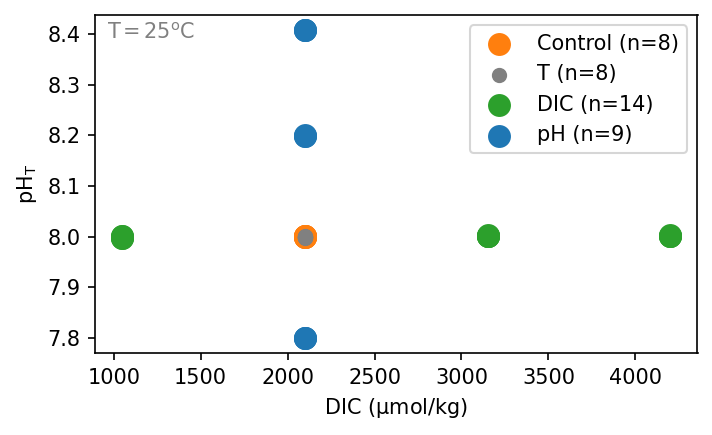

In [4]:
fig, ax = plt.subplots(1, 1)

for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    s = 100
    if e == 'T':
        s = 40
    ax.scatter(df.loc[ind, (database, 'C(mol/kgw)')] * 1e6, df.loc[ind, (database, 'pH')], label=f'{e} (n={sum(ind)})', color=c, s=s)

ax.text(.02, .98, '$T=25^oC$', va='top', ha='left', color=(.5,.5,.5), transform=ax.transAxes)
ax.legend(fontsize=10)

ax.set_ylabel('$pH_T$')
ax.set_xlabel('DIC ($\mu mol/kg$)')

fig.tight_layout()

savefig(fig, 'S1_Matrix')

## Results 1: Individual effects

In [5]:
def line(x, m, c):
    return x * m + c

def fit_line(x, y):
    nona = ~np.isnan(x) & ~np.isnan(y)
    
    return un.correlated_values(*curve_fit(line, x[nona], y[nona]))

def plot_line(ax, coef, **kwargs):
    xlim = ax.get_xlim()
    ax.set_xlim(xlim)
    
    xn = np.linspace(*xlim, 50)
    yn = line(xn, *coef)
    
    ax.plot(xn, nominal_values(yn), **kwargs)
    ax.fill_between(xn, nominal_values(yn) - 1.96 * std_devs(yn), nominal_values(yn) + 1.96 * std_devs(yn), alpha=0.2, **kwargs, lw=0)

In [6]:
xvar = 'pH'
if xvar == 'C(mol/kgw)':
    m = 1e6
    v = 'DIC'
elif xvar == 'pH':
    m = 1
    v = 'pH'
elif xvar == 'temp(C)':
    m = 1
    v = 'T'
else:
    vind = np.ones(df.shape[0], dtype=bool)
    m = 1
vind = df.labels.Experiment.str.contains(v)



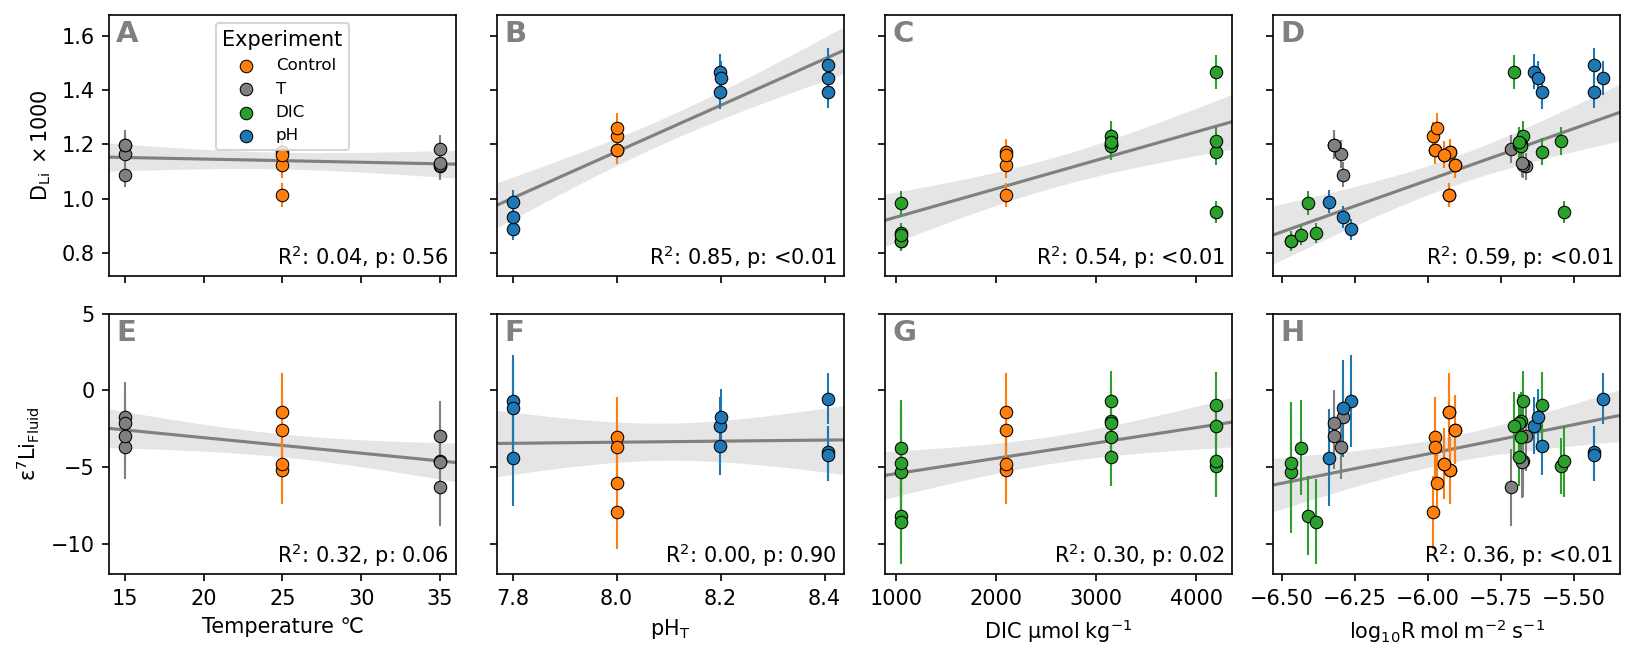

In [7]:
fig, axs = plt.subplots(2, 4, sharey='row', sharex='col', figsize=[11, 4.5])
# fig, axs = plt.subplots(2, 5, figsize=(14, 5), sharey='row', sharex='col')

axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\epsilon^7Li_{Fluid}$')
rdax, rpax = axs[:, -1]

for i, xvar in enumerate(['temp(C)', 'pH', 'C(mol/kgw)']):
    dax, pax = axs.T[i]
    if xvar == 'C(mol/kgw)':
        m = 1e6
        v = 'DIC'
    elif xvar == 'pH':
        m = 1
        v = 'pH'
    elif xvar == 'temp(C)':
        m = 1
        v = 'T'
    else:
        vind = np.ones(df.shape[0], dtype=bool)
        m = 1

    control_grp = df.loc[vind, ('labels', 'Control')].unique().item()
    cind = df.labels.Experiment.str.contains(f'Control{control_grp:.0f}')
    vind = df.labels.Experiment.str.contains(v)
    color = cdict[v]
    lw=0.5
    
    for ind, c in zip([vind, cind], [color, cdict['Control']]):
        dax.errorbar(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     xerr=err(df.loc[ind, (database, xvar)]) * m, yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=0, elinewidth=1, color=c, zorder=-1)
        dax.scatter(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                    lw=lw, edgecolor='k', color=c, zorder=1)
                
        pax.errorbar(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     xerr=err(df.loc[ind, (database, xvar)]) * m, yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     lw=0, elinewidth=1, color=c, zorder=-1)
        pax.scatter(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                    lw=lw, edgecolor='k', color=c, zorder=1)
        
        rdax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                      xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                      lw=0, elinewidth=1, color=c, zorder=-1)
        rdax.scatter(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=lw, edgecolor='k', color=c, zorder=1)
        rpax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                      xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                      lw=0, elinewidth=1, color=c, zorder=-1)
        rpax.scatter(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     lw=lw, edgecolor='k', color=c, zorder=1)
        
    dp = fit_line(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
    dreg = stats.linregress(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
    plot_line(dax, dp, zorder=-3, color='gray')
    ptext = f'{dreg.pvalue:.2f}' if dreg.pvalue > 0.01 else '<0.01'
    dax.text(0.98, 0.02, f'$R^2$: {dreg.rvalue**2:.2f}, p: {ptext}', transform=dax.transAxes, ha='right', va='bottom')
    
    pp = fit_line(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
    preg = stats.linregress(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
    plot_line(pax, pp, zorder=-3, color='gray')
    ptext = f'{preg.pvalue:.2f}' if preg.pvalue > 0.01 else '<0.01'
    pax.text(0.98, 0.02, f'$R^2$: {preg.rvalue**2:.2f}, p: {ptext}', transform=pax.transAxes, ha='right', va='bottom')
    
axs[1,0].set_xlabel('Temperature ℃')
axs[1,1].set_xlabel('$pH_T$')
axs[1,2].set_xlabel('DIC $\mu mol~kg^{-1}$')
axs[1,3].set_xlabel('$log_{10}R~mol~m^{-2}~s^{-1}$')

dp = fit_line(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
dreg = stats.linregress(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
plot_line(rdax, dp, zorder=-3, color='gray')
ptext = f'{dreg.pvalue:.2f}' if dreg.pvalue > 0.01 else '<0.01'
rdax.text(0.98, 0.02, f'$R^2$: {dreg.rvalue**2:.2f}, p: {ptext}', transform=rdax.transAxes, ha='right', va='bottom')

pp = fit_line(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
preg = stats.linregress(nom(df.loc[vind | cind, ('R', 'log10R_13C')]), nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'epsilon_og')]))
plot_line(rpax, pp, zorder=-3, color='gray')
ptext = f'{preg.pvalue:.2f}' if preg.pvalue > 0.01 else '<0.01'
rpax.text(0.98, 0.02, f'$R^2$: {preg.rvalue**2:.2f}, p: {ptext}', transform=rpax.transAxes, ha='right', va='bottom')

rpax.set_ylim(-12, 5)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

for label in cdict:
    axs[0,0].scatter([], [], label=label, color=cdict[label], lw=lw, edgecolor='k')

axs[0,0].legend(fontsize=8, title='Experiment')

# axs[1,0].set_ylim(-9, 0)
fig.tight_layout()

savefig(fig, '01_IndividualEffects')

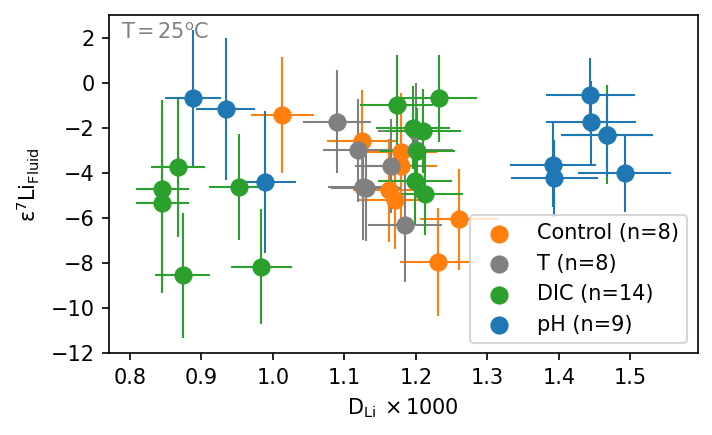

In [8]:
fig, ax = plt.subplots(1, 1)

for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    s = 60

    ax.scatter(nom(df.loc[ind, ('OG', 'DLi')]) * 1e3, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]), label=f'{e} (n={sum(ind)})', color=c, s=s)
    ax.errorbar(nom(df.loc[ind, ('OG', 'DLi')]) * 1e3, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                xerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3, yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                lw=0, elinewidth=1, color=c, zorder=-1)
    
ax.text(.02, .98, '$T=25^oC$', va='top', ha='left', color=(.5,.5,.5), transform=ax.transAxes)
ax.legend(fontsize=10)

ax.set_ylabel('$\epsilon^7Li_{Fluid}$')
ax.set_xlabel('$D_{Li}\ \\times 1000$')

fig.tight_layout()

## 2. Comparison to Previous

In [9]:
lit = pd.read_pickle('data/processed_LiDataLiterature.pkl')

rdict = {
    'Gabitov2019': 'Gabitov et al. (2019)',
    'Langer2015': 'Langer et al. (2015)', 
    'Marriott2004a': 'Mariott et al. (2004a)', 
    'Marriott2004b': 'Mariott et al. (2004b)', 
    'Roberts2018': 'Roberts et al. (2018)', 
    'Vigier2015': 'Vigier et al. (2015)',
    'Fuger2019': 'Fuger et al. (2019, 2022)',
    'Day2021': 'Day et al. (2021)',
}

mdict = {
    'Gabitov2019': ('C2', '^'),
    'Langer2015': ('C5', 'd'),
    'Marriott2004a': ('C4', '<'),
    'Marriott2004b': ('C4', '>'),
    'Roberts2018': ('C6', '+'),
    'Vigier2015': ('C7', 'x'),
    'Fuger2019': ('C3', 's'),
    'Day2021': ('C2', 'v'),
}

In [10]:
sdf

Li_isotopes_alpha_LSVEC                            \
                                     OG                fluid_post   
Experiment                                                          
0.5 x [DIC]Ctrl         0.3285+/-0.0007  0.3305186461615776+/-nan   
1.5 x [DIC]Ctrl         0.3298+/-0.0004  0.3303057162217682+/-nan   
2 x [DIC]Ctrl           0.3293+/-0.0006  0.3306050177628002+/-nan   
Control1                0.3292+/-0.0006  0.3304262414454947+/-nan   
Control2                0.3299+/-0.0007         0.33162+/-0.00010   
T = 15°C              0.33125+/-0.00029           0.3318+/-0.0009   
T = 35°C                0.3299+/-0.0005  0.3319063570352835+/-nan   
pH 7.8                  0.3297+/-0.0007   0.330461856064681+/-nan   
pH 8.2                0.32967+/-0.00032  0.3305238287668085+/-nan   
pH 8.4                  0.3296+/-0.0007  0.3305128278261297+/-nan   

                                                              \
                                fluid_pre              solid   
Experiment                                                     
0.5 x [DIC]Ctrl   0.330493200380198+/-nan    0.3384+/-0.0025   
1.5 x [DIC]Ctrl  0.3306445109322597+/-nan    0.3356+/-0.0004   
2 x [DIC]Ctrl    0.3303989955893501+/-nan    0.3357+/-0.0011   
Control1         0.3303641147555624+/-nan    0.3363+/-0.0011   
Control2                0.33180+/-0.00031    0.3374+/-0.0012   
T = 15°C                  0.3317+/-0.0006    0.3378+/-0.0005   
T = 35°C         0.3314798607852148+/-nan  0.33716+/-0.00015   
pH 7.8           0.3304293074856821+/-nan    0.3392+/-0.0006   
pH 8.2           0.3305183560643006+/-nan  0.33534+/-0.00032   
pH 8.4           0.3305244775027232+/-nan    0.3347+/-0.0006   

                Li_isotopes_vs_fluid                MassBalance  \
                            alpha_og  epsilon_og           f_og   
Experiment                                                        
0.5 x [DIC]Ctrl      0.9939+/-0.0021  -6.1+/-2.1    0.40+/-0.04   
1.5 x [DIC]Ctrl      0.9976+/-0.0014  -2.4+/-1.4  0.404+/-0.007   
2 x [DIC]Ctrl        0.9968+/-0.0019  -3.2+/-1.9    0.37+/-0.04   
Control1             0.9965+/-0.0018  -3.5+/-1.8  0.394+/-0.006   
Control2             0.9948+/-0.0022  -5.2+/-2.2  0.363+/-0.010   
T = 15°C             0.9974+/-0.0009  -2.6+/-0.9  0.407+/-0.006   
T = 35°C             0.9954+/-0.0014  -4.6+/-1.4  0.388+/-0.016   
pH 7.8               0.9979+/-0.0020  -2.1+/-2.0  0.373+/-0.018   
pH 8.2               0.9974+/-0.0010  -2.6+/-1.0  0.406+/-0.007   
pH 8.4               0.9971+/-0.0021  -2.9+/-2.1  0.411+/-0.011   

                                                                   \
                                     og_A                og_alpha   
Experiment                                                          
0.5 x [DIC]Ctrl  0.015337041205729023+/-0    1.39319587515029+/-0   
1.5 x [DIC]Ctrl  0.015337041205729023+/-0    1.39319587515029+/-0   
2 x [DIC]Ctrl    0.015337041205729025+/-0    1.39319587515029+/-0   
Control1         0.015337041205729025+/-0    1.39319587515029+/-0   
Control2         0.015337041205729025+/-0    1.39319587515029+/-0   
T = 15°C         0.015346325236924451+/-0  1.3940523678795471+/-0   
T = 35°C         0.015327747395653634+/-0  1.3923384964528225+/-0   
pH 7.8           0.015337041205729025+/-0  1.3931958751502898+/-0   
pH 8.2           0.015337041205729025+/-0  1.3931958751502898+/-0   
pH 8.4           0.015337041205729025+/-0  1.3931958751502898+/-0   

                                      ...                    solution  \
                            sample_A  ...                    pre_LiCa   
Experiment                            ...                               
0.5 x [DIC]Ctrl    0.01263+/-0.00017  ...    0.035636482701235914+/-0   
1.5 x [DIC]Ctrl  0.012667+/-0.000032  ...   0.04224072983110854+/-nan   
2 x [DIC]Ctrl      0.01251+/-0.00018  ...   0.04536750088305571+/-nan   
Control1         0.012625+/-0.000026  ...   0.04032261138371114+/-nan   
Cont

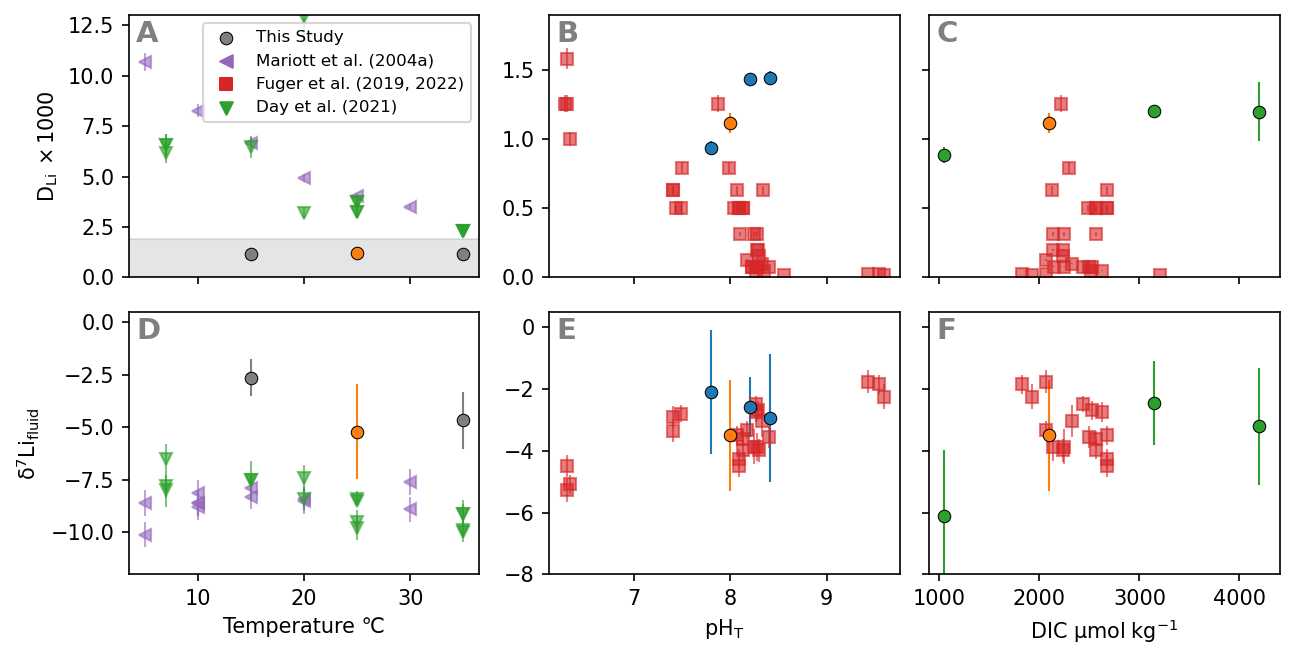

In [11]:
inorg = lit.loc['calcite']
epar = {'lw': 0,
        'elinewidth': 1,
        'alpha': 0.6}

# fig, axs = plt.subplots(2, 3, sharey=False, sharex='col', figsize=[9, 4.5], constrained_layout=True)
fig = plt.figure(figsize=[9, 4.5])
gs = GridSpec(2, 3, fig)

p00 = fig.add_subplot(gs[0, 0])
p10 = fig.add_subplot(gs[1, 0], sharex=p00)

p01 = fig.add_subplot(gs[0, 1])
p11 = fig.add_subplot(gs[1, 1], sharex=p01)

p02 = fig.add_subplot(gs[0, 2], sharey=p01)
p12 = fig.add_subplot(gs[1, 2], sharey=p11, sharex=p02)

axs = np.array([[p00, p10],[p01, p11],[p02, p12]]).T


for i, xvar in enumerate(['temp(C)', 'pH', 'C(mol/kgw)']):
    dax, pax = axs.T[i]
    if xvar == 'C(mol/kgw)':
        m = 1e6
        v = 'DIC'
    elif xvar == 'pH':
        m = 1
        v = 'pH'
    elif xvar == 'temp(C)':
        m = 1
        v = 'T'
    else:
        vind = np.ones(sdf.shape[0], dtype=bool)
        m = 1

    vind = sdf.index.str.contains(v)
    control_grp = nom(sdf.loc[vind, ('labels', 'Control')].unique().item())
    cind = sdf.index.str.contains(f'Control{control_grp:.0f}')
    # cind = sdf.index.str.contains('Control')
    color = cdict[v]
    lw=0.5
    
    for ind, c in zip([vind, cind], [color, cdict['Control']]):
        dax.errorbar(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                     xerr=err(sdf.loc[ind, (database, xvar)]) * m, yerr=err(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=0, elinewidth=1, color=c, zorder=-1)
        dax.scatter(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                    lw=lw, edgecolor='k', color=c, zorder=20)
                
        pax.errorbar(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     xerr=err(sdf.loc[ind, (database, xvar)]) * m, yerr=err(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                     lw=0, elinewidth=1, color=c, zorder=-1)
        pax.scatter(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                    lw=lw, edgecolor='k', color=c, zorder=20)
        
axs[0,0].scatter([],[], c='grey', label='This Study', edgecolor='k', lw=0.5)

whos = ['Marriott2004a', 'Fuger2019', 'Day2021']
for who in whos:
    c, m = mdict[who]
    
    dax, pax = axs.T[0]
    if 'Marriott' in who or 'Day' in who:
        dax.errorbar(inorg.loc[who, ('solution', 'TempC')], inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, ('solution', 'TempC')], inorg.loc[who, ('solid', 'epsilon_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'epsilon_7Li_2std')],
                     marker=m, color=c, **epar)
        
    if 'Fuger' in who:
        dax, pax = axs.T[1]
        dax.errorbar(inorg.loc[who, (database, 'pH')], inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, (database, 'pH')], inorg.loc[who, ('solid', 'epsilon_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'epsilon_7Li_2std')],
                     marker=m, color=c, **epar)
        
        dax, pax = axs.T[2]
        dax.errorbar(inorg.loc[who, (database, 'C(mol/kgw)')] * 1e6, inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, (database, 'C(mol/kgw)')] * 1e6, inorg.loc[who, ('solid', 'epsilon_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'epsilon_7Li_2std')],
                     marker=m, color=c, **epar)

    axs[0,0].scatter([], [], marker=m, color=c, label=rdict[who])
                    
axs[0,0].legend(fontsize=8)

axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\delta^7Li_{fluid}$')

axs[1,0].set_xlabel('Temperature ℃')
axs[1,1].set_xlabel('$pH_T$')
axs[1,2].set_xlabel('DIC $\mu mol~kg^{-1}$')

axs[1,2].set_xlim(900, 4400)

axs[0,0].set_ylim(0, 13)
axs[0,1].set_ylim(0, 1.9)

axs[1,0].set_ylim(-12, 0.5)
axs[1,1].set_ylim(-8, 0.5)

for ax in axs[0,:]:
    plt.setp(ax.get_xticklabels(), visible=False)

for ax in axs[:, 2]:
    plt.setp(ax.get_yticklabels(), visible=False)

fig.tight_layout()

for ax in axs[:, 2]:
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.03, pos.y0,  pos.width, pos.height])

axs[0,0].axhspan(*axs[0,1].get_ylim(), color='grey', alpha=0.2)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

savefig(fig, '02_PublishedComparison')

## 3. Rate Plots

In [12]:
fug = inorg.loc['Fuger2019', :]
epar = {'lw': 0,
        'elinewidth': 1}

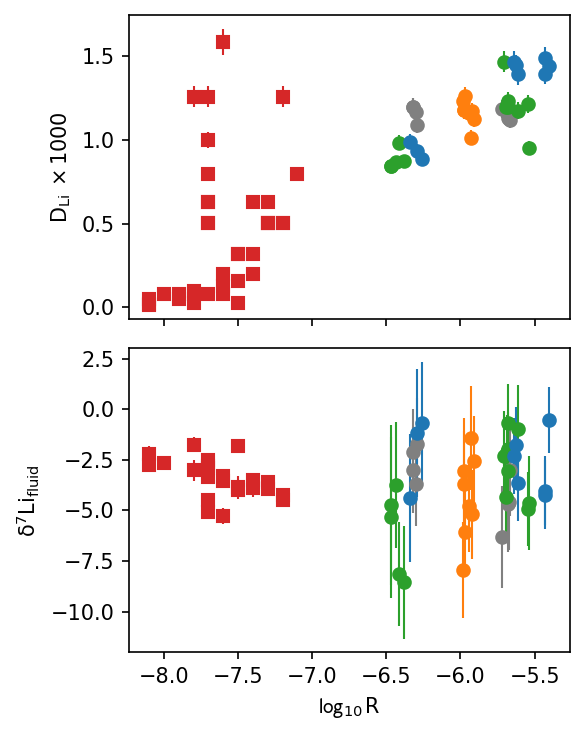

In [13]:
fig, (bax, pax) = plt.subplots(2, 1, figsize=(4, 5), sharex='col')

pax.set_xlabel('$\log_{10}R$')
bax.set_ylabel('$D_{Li}\ \\times 1000$')
pax.set_ylabel('$\delta^7Li_{fluid}$')

bax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, fug.loc[:, ('solid', 'DLi_2std')] * 1e3, color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
pax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')], fug.loc[:, ('solid', 'epsilon_7Li_2std')], color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)

# bax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3, 
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
# pax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)


for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    bax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                 xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                 marker='o', color=c, **epar)

    pax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 marker='o', color=c, **epar)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-12, 3)

fig.tight_layout()


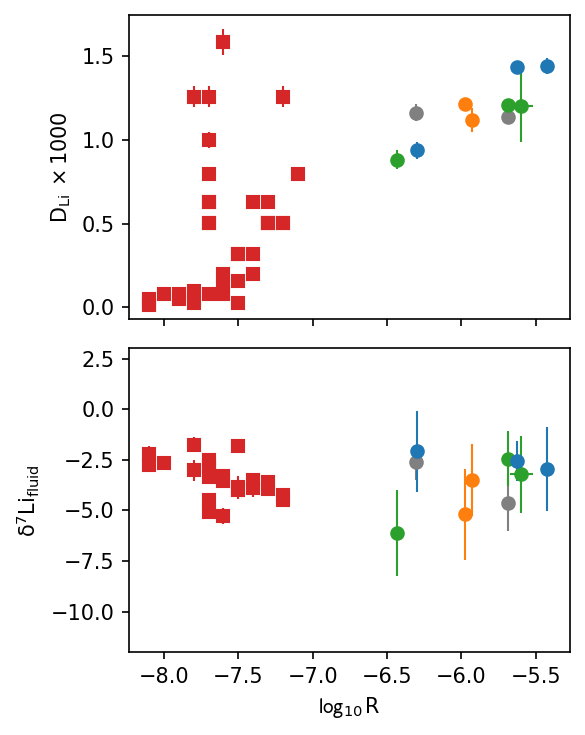

In [14]:
fig, (bax, pax) = plt.subplots(2, 1, figsize=(4, 5), sharex='col')

pax.set_xlabel('$\log_{10}R$')
bax.set_ylabel('$D_{Li}\ \\times 1000$')
pax.set_ylabel('$\delta^7Li_{fluid}$')

bax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, fug.loc[:, ('solid', 'DLi_2std')] * 1e3, color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
pax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')], fug.loc[:, ('solid', 'epsilon_7Li_2std')], color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)

# bax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3, 
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
# pax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)


for e, c in cdict.items():
    ind = sdf.index.str.contains(e)
    bax.errorbar(nom(sdf.loc[ind, ('R', 'log10R_13C')]), nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                 xerr=err(sdf.loc[ind, ('R', 'log10R_13C')]), yerr=err(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                 marker='o', color=c, **epar)

    pax.errorbar(nom(sdf.loc[ind, ('R', 'log10R_13C')]), nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 xerr=err(sdf.loc[ind, ('R', 'log10R_13C')]), yerr=err(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 marker='o', color=c, **epar)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-12, 3)

fig.tight_layout()


/tmp/ipykernel_283578/1187103129.py:120: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[0,0].scatter([],[],marker='o', label='This Study', color='w', **cargs)
/tmp/ipykernel_283578/1187103129.py:121: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[0,0].scatter([],[],marker='s', label='Fuger et al. (2019, 2022)', color='w', **cargs)


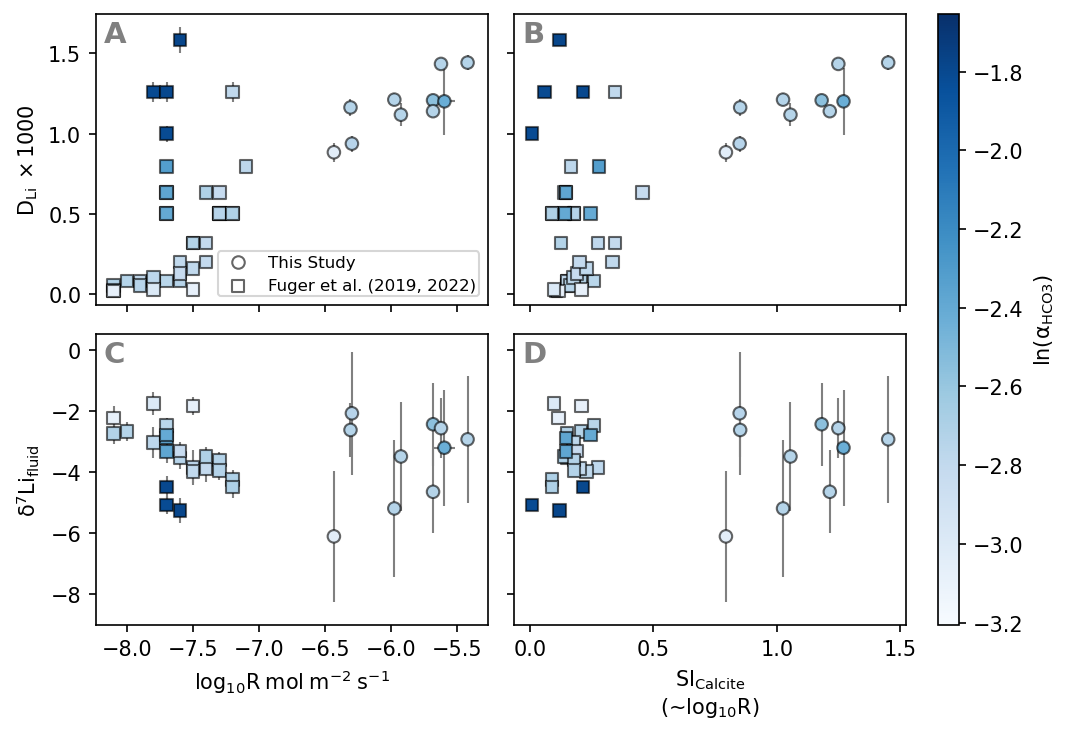

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex='col', sharey='row')

pdf = sdf
# cvar = (database, 'pH')
# clabel = cvar[-1]
cvar = (database, 'la_OH-')
cvar = (database, 'la_HCO3-')
clabel = r'$ln(\alpha_{HCO3})$'
# clabel = r'$ln(\alpha_{OH})$'

# logR plot

bax, pax = axs[:,0]

pax.set_xlabel('$log_{10}R~mol~m^{-2}~s^{-1}$')

clim = np.concatenate([fug.loc[:, cvar].values, pdf.loc[:, cvar].values])
cargs = {
    'vmin': np.nanmin(clim) - np.ptp(clim) * 0.1,
    'vmax': np.nanmax(clim) + np.ptp(clim) * 0.1,
    'cmap': plt.cm.Blues,
    'lw': 1,
    'edgecolor': (0,0,0,.6)
}

bax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

pax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')],
             yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
             **epar, zorder=-1, color='grey')
pax.scatter(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.loc[:, cvar]), **cargs)

pax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]), c=nom(pdf.loc[:, cvar]), **cargs)

# SI Calcite plot

bax, pax = axs[:,1]

pax.set_xlabel('$SI_{Calcite}$\n(~$log_{10}R$)')

bax.errorbar(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=err(fug.loc[:, ('solid', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

pax.scatter(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'epsilon_7Li')], 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.loc[:, cvar]), **cargs)

pax.errorbar(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]), c=nom(pdf.loc[:, cvar]), **cargs)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-9, 0.5)

# # calc_R plot

# bax, pax = axs[:,1]

# pax.set_xlabel('$log_{10}R~mol~m^{-2}~s^{-1}$ \n calculated from saturation')

# bax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'DLi')] * 1e3,
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3,
#              **epar, zorder=-1, color='grey')
# bax.scatter(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
#             c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

# pax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'epsilon_7Li')],
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
#              **epar, zorder=-1, color='grey')
# pax.scatter(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
#             c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

# bax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
#              xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
#              **epar, zorder=-1, color='grey')
# bax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.loc[:, cvar]), **cargs)

# pax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
#              xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
#              **epar, zorder=-1, color='grey')
# ma = pax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]), c=nom(pdf.loc[:, cvar]), **cargs)

# # pax.set_xlim(-6.6, -5.3)
# pax.set_ylim(-9, 0.5)


axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\delta^7Li_{fluid}$')

fig.tight_layout()

fig.subplots_adjust(right=0.87)
cax = fig.add_axes([.9, pax.get_position().y0, .02, bax.get_position().y1 - pax.get_position().y0])
fig.colorbar(ma, cax, label=clabel)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

axs[0,0].scatter([],[],marker='o', label='This Study', color='w', **cargs)
axs[0,0].scatter([],[],marker='s', label='Fuger et al. (2019, 2022)', color='w', **cargs)
axs[0,0].legend(fontsize=8, borderpad=0.2)

savefig(fig, '03_Rate_SI')

/tmp/ipykernel_283578/3811333669.py:90: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[1,0].scatter([],[],marker='o', label='This Study', color='w', **cargs)
/tmp/ipykernel_283578/3811333669.py:91: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[1,0].scatter([],[],marker='s', label='Fuger et al. (2019, 2022)', color='w', **cargs)


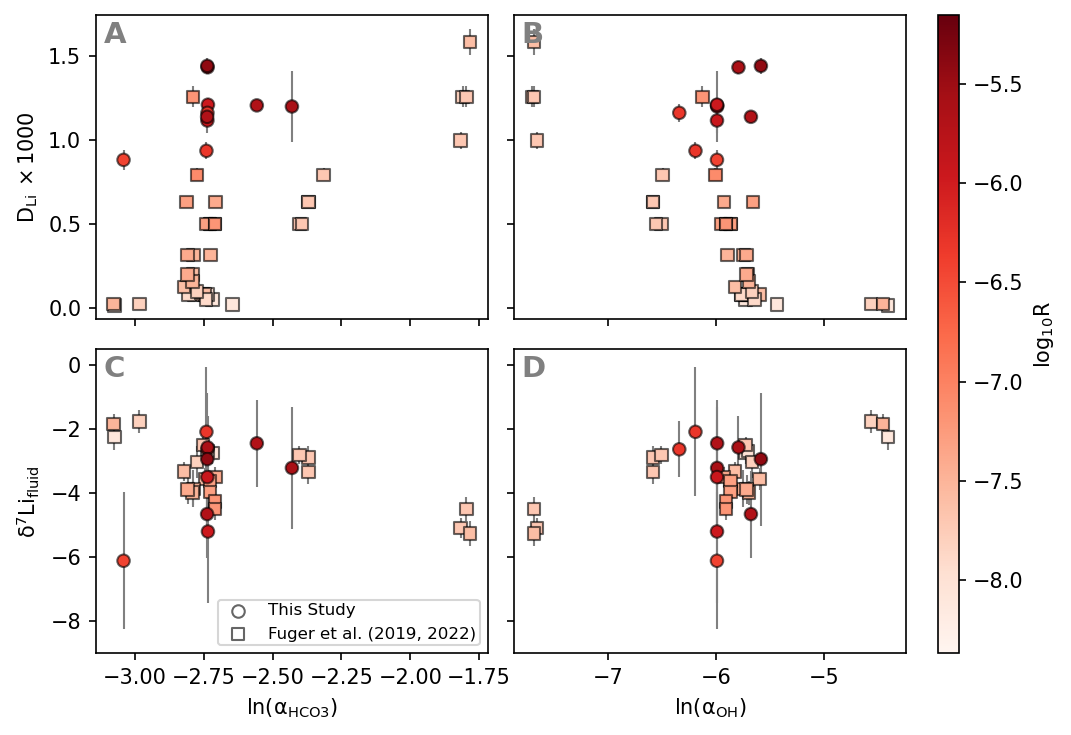

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex='col', sharey='row')

pdf = sdf
# cvar = (database, 'la_HCO3-')

clabel = r'$log_{10}R$'
clim = np.concatenate([fug.loc[:, ('solid', 'logR')].values, nom(pdf.R.log10R_13C.values)])
cargs = {
    'vmin': np.nanmin(clim) - np.ptp(clim) * 0.1,
    'vmax': np.nanmax(clim) + np.ptp(clim) * 0.1,
    'cmap': plt.cm.Reds,
    'lw': 1,
    'edgecolor': (0,0,0,.6)
}

# la_HCO3- plot
bax, pax = axs[:,0]

xvar = (database, 'la_HCO3-')
pax.set_xlabel('$ln(\\alpha_{HCO3})$')

bax.errorbar(fug.loc[:, xvar], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, xvar], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, ('solid', 'logR')], marker=mdict['Fuger2019'][1], **cargs)

pax.errorbar(fug.loc[:, xvar], fug.loc[:, ('solid', 'epsilon_7Li')],
             yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
             **epar, zorder=-1, color='grey')
pax.scatter(fug.loc[:, xvar], fug.loc[:, ('solid', 'epsilon_7Li')], 
            c=fug.loc[:, ('solid', 'logR')], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             xerr=err(pdf.loc[:, xvar]), yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.R.log10R_13C.values), **cargs)

pax.errorbar(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             xerr=err(pdf.loc[:, xvar]), yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]), c=nom(pdf.R.log10R_13C.values), **cargs)

# la_OH-- plot

bax, pax = axs[:,1]

xvar = (database, 'la_OH-')
pax.set_xlabel('$ln(\\alpha_{OH})$')


bax.errorbar(fug.loc[:, xvar], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, xvar], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, ('solid', 'logR')], marker=mdict['Fuger2019'][1], **cargs)

pax.errorbar(fug.loc[:, xvar], fug.loc[:, ('solid', 'epsilon_7Li')],
             yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
             **epar, zorder=-1, color='grey')
pax.scatter(fug.loc[:, xvar], fug.loc[:, ('solid', 'epsilon_7Li')], 
            c=fug.loc[:, ('solid', 'logR')], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             xerr=err(pdf.loc[:, xvar]), yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.R.log10R_13C.values), **cargs)

pax.errorbar(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             xerr=err(pdf.loc[:, xvar]), yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, xvar]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'epsilon_og')]), c=nom(pdf.R.log10R_13C.values), **cargs)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-9, 0.5)


axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\delta^7Li_{fluid}$')

fig.tight_layout()

fig.subplots_adjust(right=0.87)
cax = fig.add_axes([.9, pax.get_position().y0, .02, bax.get_position().y1 - pax.get_position().y0])
fig.colorbar(ma, cax, label=clabel)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

axs[1,0].scatter([],[],marker='o', label='This Study', color='w', **cargs)
axs[1,0].scatter([],[],marker='s', label='Fuger et al. (2019, 2022)', color='w', **cargs)
axs[1,0].legend(fontsize=8, borderpad=0.2, loc='lower right')

savefig(fig, '04_OH_HCO3_activity')

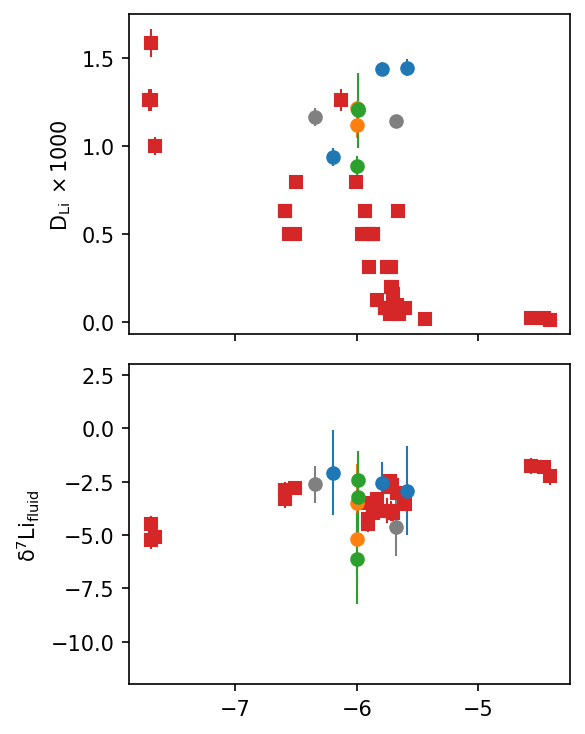

In [17]:
fig, (bax, pax) = plt.subplots(2, 1, figsize=(4, 5), sharex='col')

xvar = (database, 'la_OH-')

# pax.set_xlabel('$\log_{10}R$')
bax.set_ylabel('$D_{Li}\ \\times 1000$')
pax.set_ylabel('$\delta^7Li_{fluid}$')

bax.errorbar(fug.loc[:, xvar], fug.loc[:, ('solid', 'DLi')] * 1e3, fug.loc[:, ('solid', 'DLi_2std')] * 1e3, color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
pax.errorbar(fug.loc[:, xvar], fug.loc[:, ('solid', 'epsilon_7Li')], fug.loc[:, ('solid', 'epsilon_7Li_2std')], color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)

# bax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3, 
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)
# pax.errorbar(fug.loc[:, ('solid', 'calc_logR')], fug.loc[:, ('solid', 'epsilon_7Li')], 
#              xerr=fug.loc[:, ('solid', 'calc_logR_2std')], yerr=fug.loc[:, ('solid', 'epsilon_7Li_2std')],
#              color=mdict['Fuger2019'][0], marker=mdict['Fuger2019'][1], **epar)


for e, c in cdict.items():
    ind = sdf.index.str.contains(e)
    bax.errorbar(nom(sdf.loc[ind, xvar]), nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                 xerr=err(sdf.loc[ind, xvar]), yerr=err(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                 marker='o', color=c, **epar)

    pax.errorbar(nom(sdf.loc[ind, xvar]), nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 xerr=err(sdf.loc[ind, xvar]), yerr=err(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'epsilon_og')]),
                 marker='o', color=c, **epar)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-12, 3)

fig.tight_layout()